# ChatGPT test

In [212]:
import numpy as np
import tbplas as tb

cell = tb.make_graphene_diamond()                 # your PrimitiveCell
kmesh = tb.gen_kmesh((120, 120, 1))               # dense mesh
solver = tb.DiagSolver(cell)
solver.config.k_points = kmesh
solver.config.prefix = "calc"
solver.config.e_min, solver.config.e_max = -10, 10
E, D = solver.calc_dos()                          # E: (N,), D: states/eV  (per cell)  :contentReference[oaicite:1]{index=1}

# --- choose how many electrons per primitive cell you want ---
g = 2                                             # spin degeneracy (change if needed)
n_e = cell.num_orb                                # example: half-filling (1 e⁻ per orbital with spin-½)

# cumulative number of states up to each energy
dE = np.diff(E).mean()
NofE = np.cumsum(D) * dE                          # states per cell up to E
Ef = E[np.searchsorted(NofE, n_e / g, side="left")]
print("E_F (eV) =", Ef)

# vis = tb.Visualizer()
# vis.plot_dos(E, D)



Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : calc

Using Eigen backend for diagonalization.
E_F (eV) = 8.350000000000001


In [213]:
NofE

array([2.21633560e-309, 1.46799609e-302, 1.07153783e-286, 2.87990414e-271,
       2.85004395e-256, 1.03859196e-241, 1.39372477e-227, 6.88761313e-214,
       1.25355580e-200, 8.40288166e-188, 2.07468552e-175, 1.88690226e-163,
       6.32204682e-152, 7.80405579e-141, 3.54965753e-130, 5.94993057e-120,
       3.67587390e-110, 8.37154954e-101, 7.02962234e-092, 2.17689050e-083,
       2.48675537e-075, 1.04822422e-067, 1.63100952e-060, 9.37186709e-054,
       1.98969564e-047, 1.56174345e-041, 4.53554634e-036, 4.87825343e-031,
       1.94556646e-026, 2.88182427e-022, 1.58875185e-018, 3.26963299e-015,
       2.52271742e-012, 7.34607993e-010, 8.16302275e-008, 3.53019359e-006,
       6.16658366e-005, 4.67284338e-004, 1.74666989e-003, 3.90276451e-003,
       6.41315268e-003, 8.98616557e-003, 1.15706828e-002, 1.41635015e-002,
       1.67646224e-002, 1.93741266e-002, 2.19920978e-002, 2.46186223e-002,
       2.72537868e-002, 2.98976708e-002, 3.25503710e-002, 3.52120236e-002,
       3.78826451e-002, 4

In [214]:
print(E.shape, energies.shape, D.shape, dos.shape, n_e)

(401,) (3766,) (401,) (3766,) 2


Output details:
  Directory  : ./
  Prefix     : graphene

Using Eigen backend for diagonalization.


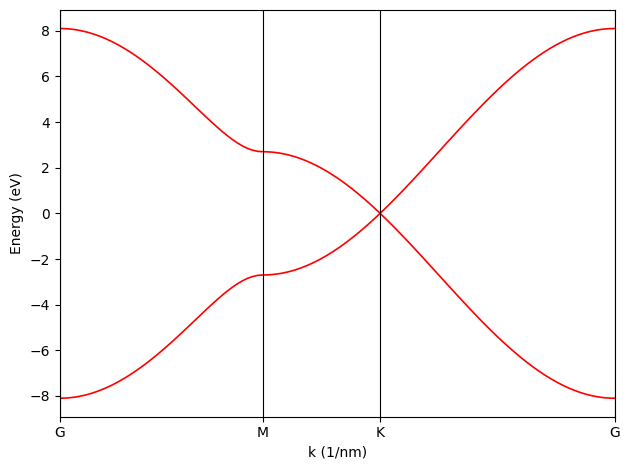

In [215]:
k_points = np.array([
    [0.0, 0.0, 0.0],    # Gamma
    [1./2, 0.0, 0.0],   # M
    [2./3, 1./3, 0.0],  # K
    [0.0, 0.0, 0.0],    # Gamma
])
k_label = ["G", "M", "K", "G"]
k_path, k_idx = tb.gen_kpath(k_points, [40, 40, 40])
solver.config.k_points = k_path
solver.config.prefix = "graphene"
k_len, bands = solver.calc_bands()

vis = tb.Visualizer()
fig_bands = vis.plot_bands(k_len, bands, k_idx, k_label)

# Extract the Fermi energy of a sample

In [216]:
import numpy as np
import tbplas as tb
import sisl
from pathlib import Path

def add_orbitals(cell: tb.PrimitiveCell, positions, onsites, labels) -> None:
    """
    Add orbitals to the model.

    There are n_atoms atoms, with n_orbs orbitals each in that same position. We will extract those orbitals from the atom info.
    """
    for i in range(positions.shape[0]):
        n_orbs = len(labels[i])
        for j in range(n_orbs):
            cell.add_orbital_cart(positions[i], unit=tb.ANG, energy=onsites[i*n_orbs+j], label=labels[i][j])


def add_hopping_terms(cell: tb.PrimitiveCell, iscs, orbs_in, orbs_out, hoppings) -> None:
    n_hops = len(iscs)
    for i in range(n_hops):
        cell.add_hopping(rn=iscs[i], orb_i=orbs_in[i], orb_j=orbs_out[i], energy=hoppings[i])


def real_space_to_kspace(positions, b1, b2, b3):
    """
    Map real-space positions into reciprocal space (fractional and cartesian).
    Returns:
        k_frac: (N, 3) positions in fractional reciprocal coordinates
        k_cart: (N, 3) positions in cartesian k-space (nm^-1)
    """
    B = np.vstack([b1, b2, b3])  # reciprocal lattice vectors (3,3), Ang^-1
    # Fractional reciprocal coordinates
    k_frac = np.linalg.solve(B.T, positions.T).T  # shape (N,3)
    # Cartesian k-vectors
    k_cart = k_frac @ B
    return k_frac, k_cart

In [217]:
path = Path("../dataset/SHARE_OUTPUTS_2_ATOMS/7bbb-6d51-41eb-9de4-329298202ebf")
file = sisl.get_sile(path / "aiida.HSX")
geometry = file.read_geometry()

vectors = geometry.cell
cell = tb.PrimitiveCell(vectors, unit=tb.ANG)

# Add orbitals
positions = geometry.xyz #Angstrom
labels = [[orb.name() for orb in atom] for atom in geometry.atoms]

# To add the orbitals we need the onsite energies.
h = file.read_hamiltonian()
h_mat = h.tocsr().tocoo()

rows = h_mat.row
cols = h_mat.col
data = h_mat.data

# Main diagonal length:
n_diag = min(h_mat.shape[0], h_mat.shape[1])

# Loop through all diagonal elements
onsites = np.zeros(n_diag, dtype=data.dtype)
for i in range(n_diag):
    # Find where both row and col equal i
    mask = (rows == i) & (cols == i)
    vals = data[mask]
    if len(vals) > 0:
        onsites[i] = vals[0]  # In COO, there could be duplicates, but take the first
    else:
        onsites[i] = 0  # Or np.nan if you prefer

# onsites = 
add_orbitals(cell, positions, onsites, labels)


# Add hopping terms.
# We need to iterate though each nnz element of h and get the isc in a tuple, the orb_in, the orb_out and the hopping value.
nnz = len(data)
n_orbs = len(labels[0]) # Assuming all atoms have the same nr of orbitals
n_atoms = int(path.parts[-2].split("_")[-2])
iscs = []
orbs_in = []
orbs_out = []
hoppings = []
for k in range(nnz):
    row = rows[k]
    col = cols[k]
    if row != col:  # Only add hopping terms for off-diagonal elements
        iscs.append(geometry.o2isc(col))
        orbs_in.append(col % (n_atoms*n_orbs))
        orbs_out.append(row)
        hoppings.append(data[k])
    

add_hopping_terms(cell, iscs, orbs_in, orbs_out, hoppings)



# Get overlap

# To add the orbitals we need the onsite energies.
o = file.read_overlap()
o_mat = o.tocsr().tocoo()

rows = o_mat.row
cols = o_mat.col
data = o_mat.data

# Main diagonal length:
n_diag = min(o_mat.shape[0], o_mat.shape[1])

# Loop through all diagonal elements
onsites = np.zeros(n_diag, dtype=data.dtype)
for i in range(n_diag):
    # Find where both row and col equal i
    mask = (rows == i) & (cols == i)
    vals = data[mask]
    if len(vals) > 0:
        onsites[i] = vals[0]  # In COO, there could be duplicates, but take the first
    else:
        onsites[i] = 0  # Or np.nan if you prefer

# Add onsites to overlap
overlap = tb.PrimitiveCell(cell.lat_vec, cell.origin, 1.0)
for i in range(cell.num_orb):
    orbital = cell.orbitals[i]
    overlap.add_orbital(orbital.position, onsites[i])


# Add hopping terms to overlap

# We need to iterate though each nnz element of h and get the isc in a tuple, the orb_in, the orb_out and the hopping value.
nnz = len(data)
n_orbs = len(labels[0]) # Assuming all atoms have the same nr of orbitals
n_atoms = int(path.parts[-2].split("_")[-2])
iscs = []
orbs_in = []
orbs_out = []
hoppings = []
for k in range(nnz):
    row = rows[k]
    col = cols[k]
    if row != col:  # Only add hopping terms for off-diagonal elements
        iscs.append(geometry.o2isc(col))
        orbs_in.append(col % (n_atoms*n_orbs))
        orbs_out.append(row)
        hoppings.append(data[k])
        

add_hopping_terms(overlap, iscs, orbs_in, orbs_out, hoppings)

In [218]:
# Define a path in k-space

b1, b2, b3 = cell.get_reciprocal_vectors()/10 # Angstrom^-1
k_pos_frac, k_pos_cart = real_space_to_kspace(positions, b1, b2, b3)

# Compute k path
B = np.vstack([b1, b2, b3])  # shape (3,3)
k_cart = np.array([[0.0, 0.0, 0.0], b3/2, b3])
k_label = ['Γ', "Z/2", "Z"]

k_frac = np.array([np.linalg.solve(B.T, k) for k in k_cart])

n_ks = 200
k_path, k_idx = tb.gen_kpath(k_frac, [n_ks for _ in range(len(k_frac) -1)])
len(k_path)

401


Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : Test

Using Eigen backend for diagonalization.
	 bands :    0.21314


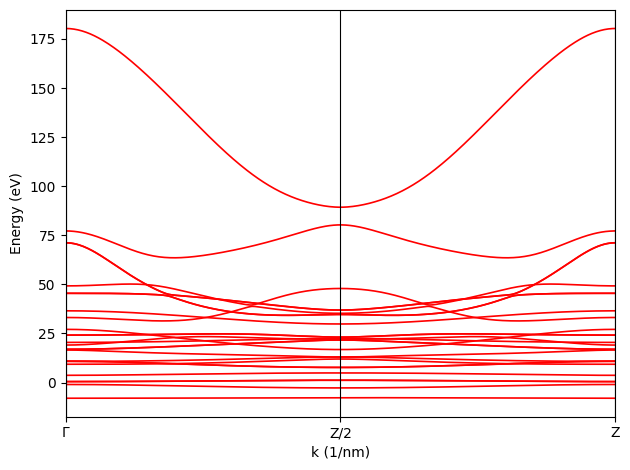

In [219]:
solver = tb.DiagSolver(cell, overlap)
solver.config.k_points = k_path
solver.config.prefix = "Test"

timer = tb.Timer()
timer.tic("bands")
k_len, bands = solver.calc_bands()
timer.toc("bands")

vis = tb.Visualizer()
timer.report_total_time()
fig_bands = vis.plot_bands(k_len, bands, k_idx, k_label)


Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : sample

Using Eigen backend for diagonalization.


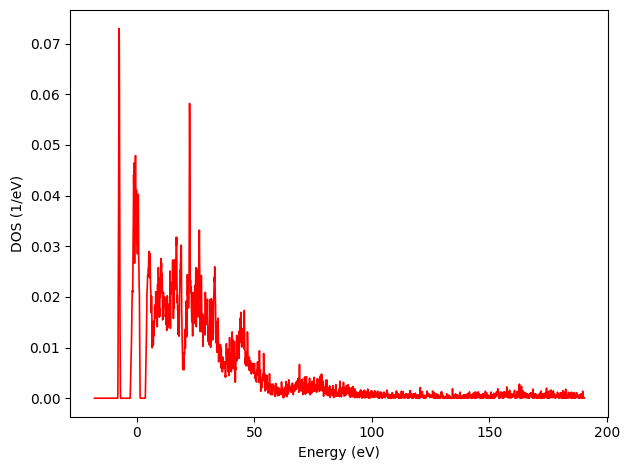

In [220]:
# DOS
n_ks=20
k_mesh = tb.gen_kmesh((n_ks, n_ks, n_ks))  # Uniform meshgrid
e_min = float(np.min(bands))
e_max = float(np.max(bands))

solver = tb.DiagSolver(cell, overlap)
solver.config.k_points = k_mesh
# solver.config.prefix = "graphene"
solver.config.e_min = e_min - 10
solver.config.e_max = e_max + 10
timer = tb.Timer()
timer.tic("dos")
energies, dos = solver.calc_dos()
timer.toc("dos")


vis = tb.Visualizer()
fig_dos = vis.plot_dos(energies, dos)

In [221]:
print(E.shape, energies.shape, D.shape, dos.shape, n_e)

(401,) (4166,) (401,) (4166,) 2


In [222]:
# --- choose how many electrons per primitive cell you want ---
g = 2                                             # spin degeneracy (change if needed)
n_e = cell.num_orb / g                                # example: half-filling (1 e⁻ per orbital with spin-½)

# cumulative number of states up to each energy
dE = np.diff(energies).mean()
NofE = np.cumsum(dos) * dE                          # states per cell up to E
computed_fermi = energies[np.searchsorted(NofE, n_e, side="left")]

IndexError: index 4166 is out of bounds for axis 0 with size 4166

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_bands(k_len, bands, k_idx, k_label, predicted_bands=None, filepath=None):
    """
    Plot band structure using Plotly.

    Parameters:
    - k_len: array-like, k-point distances
    - bands: 2D array, shape (n_kpoints, n_bands), true bands
    - k_idx: list of indices where vertical lines are drawn
    - k_label: list of labels for xticks
    - predicted_bands: optional 2D array, same shape as `bands`
    """
    fig = go.Figure()
    num_bands = bands.shape[1]

    # True bands: solid black
    for i in range(num_bands):
        fig.add_trace(go.Scatter(
            x=k_len,
            y=bands[:, i],
            mode='lines',
            name='True bands',                
            legendgroup='true_bands',        
            showlegend=(i == 0),              
            line=dict(color='red', width=2, dash='solid')
        ))

    # Predicted bands: dashed black
    if predicted_bands is not None:
        for i in range(num_bands):
            fig.add_trace(go.Scatter(
                x=k_len,
                y=predicted_bands[:, i],
                mode='lines',
                name='Predicted bands', 
                legendgroup='pred_bands',
                showlegend=(i == 0),
                line=dict(color='red', width=2, dash='dash'),
            ))

    # Vertical lines
    for idx in k_idx:
        fig.add_shape(type="line",
                      x0=k_len[idx], y0=bands.min(), x1=k_len[idx], y1=bands.max(),
                      line=dict(color="black", width=2))

    # Layout
    fig.update_layout(
        xaxis=dict(
            title="k (1/nm)",
            tickmode='array',
            tickvals=[k_len[i] for i in k_idx],
            ticktext=k_label,
            ticks='',  # Hide tick marks
            showticklabels=True,
            range=[0, k_len.max()],
        ),
        yaxis=dict(title="Energy (eV)"),
        margin=dict(l=50, r=20, t=20, b=50),
        showlegend=True,
        plot_bgcolor='white',
    )

    # === Output ===
    if filepath is not None:
        if filepath.suffix.lower() == ".html":
            fig.write_html(str(filepath))
        elif filepath.suffix.lower() == ".png":
            fig.write_image(str(filepath), height=1200, width=900,)
        else:
            raise ValueError(f"Unsupported file extension: {filepath.suffix}")
        
    else:
        fig.show()

    return fig

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_bands_matplotlib(k_len, bands, k_idx, k_label,
                          predicted_bands=None, filepath=None,
                          ylim=None, fermi_lvl=None, legend_loc=None):
    k_len = np.asarray(k_len)
    bands = np.asarray(bands)
    assert bands.ndim == 2, "bands must be (n_kpoints, n_bands)"

    fig, ax = plt.subplots(figsize=(4, 5), facecolor="white")
    ax.set_facecolor("white")

    # True bands: label only on the first column
    ax.plot(k_len, bands[:, 0], color="red", lw=2, label="True bands")
    ax.plot(k_len, bands[:, 1:], color="red", lw=2)  # no label

    # Predicted bands
    if predicted_bands is not None:
        predicted_bands = np.asarray(predicted_bands)
        assert predicted_bands.shape == bands.shape
        ax.plot(k_len, predicted_bands[:, 0], color="red", lw=2, ls="--", label="Predicted bands")
        ax.plot(k_len, predicted_bands[:, 1:], color="red", lw=2, ls="--")  # no label

    # Decide vertical line span
    if ylim is not None:
        vmin, vmax = ylim
    else:
        vmin = np.nanmin(bands if predicted_bands is None else np.dstack((bands, predicted_bands)))
        vmax = np.nanmax(bands if predicted_bands is None else np.dstack((bands, predicted_bands)))

    # Vertical separators
    ax.vlines(k_len[np.asarray(k_idx, int)], vmin, vmax, colors="black", lw=2)

    # Optional Fermi level
    if fermi_lvl is not None:
        ax.axhline(fermi_lvl, color="grey", ls="--", lw=2, label="Fermi level")

    # Axes & ticks
    ax.set_xlabel(r"$k$ ($1/\AA$)")
    ax.set_ylabel("Energy (eV)")
    ax.set_xlim(k_len.min(), k_len.max())
    ax.set_xticks(k_len[np.asarray(k_idx, int)])
    ax.set_xticklabels(k_label)
    if ylim is not None:
        ax.set_ylim(ylim)

    # Styling
    ax.tick_params(direction="out")
    for s in ax.spines.values():
        s.set_color("black")

    if legend_loc is None:
        legend_loc = "best"
    ax.legend(loc=legend_loc)
    fig.tight_layout()

    if filepath:
        fig.savefig(str(filepath), dpi=150, bbox_inches="tight")
    else:
        plt.show()

    return fig, ax


In [ ]:
import re

def read_fermi_level(path: str) -> float:
    """
    Return the last reported Fermi level (in eV) from a SIESTA aiida.out file.
    """
    pat = re.compile(r'Fermi\s*=\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)')
    fermi = None
    with open(path, encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            m = pat.search(line)
            if m:
                fermi = float(m.group(1))
    if fermi is None:
        raise ValueError("Fermi level not found in file.")
    return fermi

# usage:
print(read_fermi_level(path / "aiida.out"))  # -> -7.117043


-7.117043


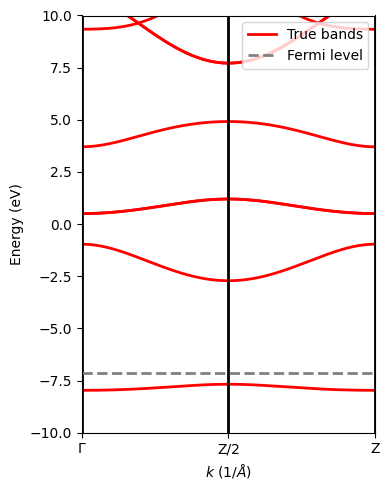

In [ ]:
k_len_plot = np.repeat(k_len[:,None], bands.shape[0], axis=1)
fermi_lvl=read_fermi_level(path / "aiida.out")
# fig_bands = plot_bands(k_len, bands, k_idx, k_label, predicted_bands=None, filepath=None)
fig_bands = plot_bands_matplotlib(k_len, bands, k_idx, k_label, predicted_bands=None, filepath=None, ylim = [-10, 10], fermi_lvl=fermi_lvl, legend_loc="upper right")

# Compare computed fermi level vs siesta fermi level

In [230]:
import numpy as np

def fermi_level_T0(energies, dos, electrons_per_cell, dos_multiplier=1.0):
    """
    Zero-temperature Fermi level from DOS by conserving electrons:
        N_e = ∫_{-∞}^{E_F} g(E) dE

    Parameters
    ----------
    energies : (N,) array (eV)
    dos : (N,) array (states / (eV·cell))
    electrons_per_cell : float
        Total electrons represented by the model (include spin, doping).
    dos_multiplier : float, default 1.0
        Use 2.0 if `dos` is per spin and you need both spins.

    Returns
    -------
    E_F : float (eV)
    """
    E = np.asarray(energies, float)
    D = np.asarray(dos, float)

    # Sort by energy and sanitize DOS
    order = np.argsort(E)
    E = E[order]
    D = np.clip(D[order] * dos_multiplier, 0.0, None)

    if E.size < 2:
        return float(E[0])

    # Cumulative trapezoidal integral: N(E_i) = ∫ g(E) dE up to E_i
    dx = np.diff(E)
    cumN = np.concatenate(([0.0], np.cumsum(0.5 * (D[1:] + D[:-1]) * dx)))
    total_states = float(cumN[-1])

    # Handle edge cases
    if total_states <= 0.0:
        # No states on grid: return mid-grid as a neutral choice
        return float(0.5 * (E[0] + E[-1]))

    Ntarget = float(np.clip(electrons_per_cell, 0.0, total_states))

    # Interpolate E_F such that cumN(E_F) = Ntarget
    E_F = float(np.interp(Ntarget, cumN, E))
    return E_F

# -------------------------
# Example usage:
# energies, dos = solver.calc_dos()
g = 2 # degeneracy due to spin
electrons_per_cell = cell.num_orb * g  # e.g., 2.0 for π-only graphene (per cell), adjust for doping
e_fermi = fermi_level_T0(energies, dos, electrons_per_cell, dos_multiplier=1.0)
print("E_F (0 K) =", e_fermi, "eV")


E_F (0 K) = 190.3229213716717 eV


In [ ]:
# Siesta fermi level:
siesta_fermi = read_fermi_level(path / "aiida.out")

# Computed fermi level (DOS needed):



print("SIESTA Fermi level:", siesta_fermi)
print("Computed Fermi level:", computed_fermi)

IndexError: index 3766 is out of bounds for axis 0 with size 3766